## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
from urllib.parse import urlparse
from scipy.stats import spearmanr

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

import time
from tqdm import tqdm

from radam import RAdam
from text_data import TextDataset
from net import NeuralNet5, GELU
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

Using TensorFlow backend.


## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train = clean_data(train, INPUTS)
test = clean_data(test,INPUTS)

In [4]:
init_seed()

In [5]:
train.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [6]:
%%time
use_feature_path = 'proc_data/use_embedding_features/'
embedding_train, embedding_test = get_use_embedding_features(train, test, INPUTS, use_feature_path)

CPU times: user 1.2 s, sys: 39.5 ms, total: 1.24 s
Wall time: 1.24 s


In [7]:
%%time
distill_bert_feature_path = 'proc_data/distill_bert_features/'
bert_features_train, bert_features_test = get_distill_bert_features(
    train, test, ['question_body', 'answer'], 64, distill_bert_feature_path)

CPU times: user 1.12 s, sys: 32 ms, total: 1.15 s
Wall time: 1.15 s


In [8]:
%%time
dist_features_train, dist_features_test  = get_dist_features(embedding_train, embedding_test)

CPU times: user 1.11 s, sys: 29.7 ms, total: 1.14 s
Wall time: 116 ms


In [9]:
tokenizer = Tokenizer()
full_text = []
for inp in INPUTS: full_text += list(train[inp])
for inp in INPUTS: full_text += list(test[inp])
tokenizer.fit_on_texts(full_text)

In [10]:
# %%time
# lemma_dict, word_dict = get_word_lemma_dict(full_text, 'proc_data/')

In [11]:
# embed_size=300
# embedding_path = 'pretrained_models/crawl-300d-2M.pkl'
# embedding_path_spellcheck = 'pretrained_models/wiki-news-300d-1M.vec'

In [12]:
# %%time
# matrix_path = 'proc_data/embedding_matrix/'
# embedding_matrix, nb_words, unknown_words = build_matrix_adv(
#     embedding_path, embedding_path_spellcheck, word_dict, lemma_dict, 100000, embed_size, matrix_path)

In [13]:
# tk.word_index = {k: v for k, v in tk.word_index.items() if k in word_dict.keys()}
# train['host'] = train['host'].apply(lambda x: x.split('.')[-2])
# test['host'] = test['host'].apply(lambda x: x.split('.')[-2])
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [14]:
# max_len = 512
# max_len_title = 32
# train_question_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['question_body']), maxlen=max_len)
# train_answer_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['answer']), maxlen=max_len)
# train_title_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['question_title']),maxlen=max_len_title)

# test_question_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['question_body']), maxlen=max_len)
# test_answer_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['answer']), maxlen=max_len)
# test_title_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['question_title']), maxlen=max_len_title)

In [15]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
merged = np.vstack([cat_features_train, cat_features_test])
ohe = OneHotEncoder()
ohe.fit(merged)

cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [16]:
x_train = np.hstack([cat_features_train, dist_features_train] + 
                    list(embedding_train.values()) +
                    list(bert_features_train.values())).astype(np.float32)
x_test = np.hstack([cat_features_test, dist_features_test] + 
                   list(embedding_test.values()) + 
                   list(bert_features_test.values())).astype(np.float32)

In [17]:
y = train[TARGETS].values.astype(np.float32)

In [18]:
num_workers = 10
bs = 32
n_cat = len(category_dict) + 1
cat_emb = int(min(np.ceil((len(category_dict)) / 2), 50))
n_host = len(host_dict) + 1
host_emb = int(min(np.ceil((len(host_dict)) / 2), 50))
n_x = x_train.shape[1]# - 2

In [19]:
bs_test = 8
test_loader = DataLoader(
    TensorDataset(torch.Tensor(x_test), torch.Tensor(np.zeros((len(x_test), N_TARGETS), dtype=np.float32))),
    batch_size=bs_test, shuffle=False, num_workers=num_workers
)

In [20]:
# class Net(nn.Module):
#     def __init__(self, n_x, n_h=512):
#         super().__init__()
#         self.head = nn.Sequential(
#             nn.Linear(n_x, n_h),
#             GELU(),#nn.ELU(inplace=True),
#             nn.Dropout(0.2),
#             nn.Linear(n_h, N_TARGETS)
#         )
        
#     def forward(self, x):
#         return self.head(x)
    
class Net(nn.Module):
    def __init__(self, n_x, n_h=512):
        super().__init__()
        self.lin = nn.Sequential(
            nn.Linear(n_x, n_h),
            GELU(),#nn.ELU(inplace=True),
            nn.Dropout(0.2),
        )
        self.lin_q = nn.Sequential(
            nn.Linear(75 + 2*512 + 768, n_h),
            GELU(),#nn.ELU(inplace=True),
            nn.Dropout(0.2),
        )
        self.lin_a = nn.Sequential(
            nn.Linear(75 + 512 + 768, n_h),
            GELU(),#nn.ELU(inplace=True),
            nn.Dropout(0.2)
        )
        self.head_q = nn.Linear(2 * n_h, 21)
        self.head_a = nn.Linear(2 * n_h, 9)
        
    def forward(self, x):
        x_feats = x[:,:75]
        x_q_emb = x[:,75:1099]
        x_a_emb = x[:,1099:1611]
        x_q_bert = x[:,1611:2379]
        x_a_bert = x[:,2379:]
        x = self.lin(x)
        x_q = self.lin_q(torch.cat([x_feats, x_q_emb, x_q_bert], dim=1))
        x_a = self.lin_a(torch.cat([x_feats, x_a_emb, x_a_bert], dim=1))
        x_q = self.head_q(torch.cat([x, x_q], dim=1))
        x_a = self.head_a(torch.cat([x, x_a], dim=1))
        return torch.cat([x_q, x_a], dim=1)

# class Net(nn.Module):
#     def __init__(self, n_x, n_cat, cat_emb, n_host, host_emb, n_h=512):
#         super().__init__()
#         self.cat_emb = nn.Embedding(n_cat, cat_emb)
#         self.host_emb = nn.Embedding(n_host, host_emb)
#         self.head = nn.Sequential(
#             nn.Linear(n_x + cat_emb + host_emb, n_h),
#             GELU(),#nn.ELU(inplace=True),
#             nn.Dropout(0.2),
#             nn.Linear(n_h, N_TARGETS)
#         )
        
#     def forward(self, x):
#         x_host = self.host_emb(x[:, 0].long())
#         x_cat = self.cat_emb(x[:, 1].long())
#         x = torch.cat([x_cat, x_host, x[:, 2:]], dim=1)
#         return self.head(x)

## Training model

In [21]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = torch.device('cuda')
n_epochs = 10
model_name = 'distil_bert'
checkpoint_dir = 'checkpoints/'
early_stopping = None

Fold 1 started at Tue Dec  3 22:13:35 2019
Net(
  (lin): Sequential(
    (0): Linear(in_features=3147, out_features=256, bias=True)
    (1): GELU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin_q): Sequential(
    (0): Linear(in_features=1867, out_features=256, bias=True)
    (1): GELU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (lin_a): Sequential(
    (0): Linear(in_features=1355, out_features=256, bias=True)
    (1): GELU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (head_q): Linear(in_features=512, out_features=21, bias=True)
  (head_a): Linear(in_features=512, out_features=9, bias=True)
)


 50%|█████     | 50/100 [00:00<00:00, 73.41it/s]


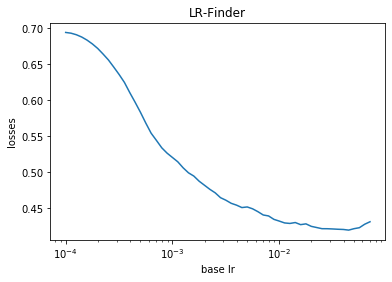

epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.48177 - spearmanr 0.083048
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.405 - spearmanr 0.25693
best model: epoch 0 - 0.25693
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39491 - spearmanr 0.27221
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.3934 - spearmanr 0.34554
best model: epoch 1 - 0.34554
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.3804 - spearmanr 0.34064
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.38431 - spearmanr 0.37038
best model: epoch 2 - 0.37038
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37057 - spearmanr 0.38001
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.37714 - spearmanr 0.38237
best model: epoch 3 - 0.38237
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36323 - spearmanr 0.40963
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.37502 - spearmanr 0.38866
best model: epoch 4 - 0.38866
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.35748 - spearmanr 0.43156
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.37498 - spearmanr 0.39073
best model: epoch 5 - 0.39073
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.3534 - spearmanr 0.44783
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.3718 - spearmanr 0.39281
best model: epoch 6 - 0.39281
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.34942 - spearmanr 0.46553
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.37194 - spearmanr 0.39264
model not improved for 1 epochs
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.34645 - spearmanr 0.47762
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.37133 - spearmanr 0.39327
best model: epoch 8 - 0.39327
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.34483 - spearmanr 0.48365
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.37114 - spearmanr 0.39316
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 8 - 0.39327
Starting inference for model: checkpoints/distil_bert_fold_1_best.pth



Starting inference for model: checkpoints/distil_bert_fold_1_best.pth



Fold 2 started at Tue Dec  3 22:14:02 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.48177 - spearmanr 0.085804
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.40346 - spearmanr 0.25582
best model: epoch 0 - 0.25582
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39522 - spearmanr 0.27479
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38466 - spearmanr 0.34408
best model: epoch 1 - 0.34408
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38055 - spearmanr 0.34418
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.37639 - spearmanr 0.37472
best model: epoch 2 - 0.37472
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37035 - spearmanr 0.38348
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.37407 - spearmanr 0.38182
best model: epoch 3 - 0.38182
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36379 - spearmanr 0.41092
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.37061 - spearmanr 0.39071
best model: epoch 4 - 0.39071
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.3583 - spearmanr 0.43283
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.36947 - spearmanr 0.39367
best model: epoch 5 - 0.39367
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35375 - spearmanr 0.45146
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.36732 - spearmanr 0.39533
best model: epoch 6 - 0.39533
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.34958 - spearmanr 0.46634
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.3676 - spearmanr 0.39717
best model: epoch 7 - 0.39717
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.34695 - spearmanr 0.47702
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.36635 - spearmanr 0.39682
model not improved for 1 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.34518 - spearmanr 0.48524
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.3663 - spearmanr 0.39614
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 7 - 0.39717
Starting inference for model: checkpoints/distil_bert_fold_2_best.pth



Starting inference for model: checkpoints/distil_bert_fold_2_best.pth



Fold 3 started at Tue Dec  3 22:14:28 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.47812 - spearmanr 0.07736
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.4007 - spearmanr 0.26061
best model: epoch 0 - 0.26061
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39592 - spearmanr 0.2679
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38357 - spearmanr 0.34809
best model: epoch 1 - 0.34809
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38187 - spearmanr 0.3372
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.3745 - spearmanr 0.37887
best model: epoch 2 - 0.37887
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37112 - spearmanr 0.38185
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.3725 - spearmanr 0.39422
best model: epoch 3 - 0.39422
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36384 - spearmanr 0.40946
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.36895 - spearmanr 0.39841
best model: epoch 4 - 0.39841
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.35887 - spearmanr 0.43178
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.36897 - spearmanr 0.402
best model: epoch 5 - 0.402
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35404 - spearmanr 0.45025
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.3672 - spearmanr 0.4027
best model: epoch 6 - 0.4027
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.35028 - spearmanr 0.46353
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.36674 - spearmanr 0.40299
best model: epoch 7 - 0.40299
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.34762 - spearmanr 0.47426
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.36644 - spearmanr 0.40282
model not improved for 1 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.34598 - spearmanr 0.48118
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.36589 - spearmanr 0.40366
best model: epoch 9 - 0.40366
TRAINING END: Best score achieved on epoch 9 - 0.40366
Starting inference for model: checkpoints/distil_bert_fold_3_best.pth



Starting inference for model: checkpoints/distil_bert_fold_3_best.pth



Fold 4 started at Tue Dec  3 22:14:54 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.48328 - spearmanr 0.074275
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.40194 - spearmanr 0.2594
best model: epoch 0 - 0.2594
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39618 - spearmanr 0.26866
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38434 - spearmanr 0.34803
best model: epoch 1 - 0.34803
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38135 - spearmanr 0.34107
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.37877 - spearmanr 0.37477
best model: epoch 2 - 0.37477
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37143 - spearmanr 0.38309
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.37144 - spearmanr 0.38858
best model: epoch 3 - 0.38858
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36504 - spearmanr 0.40668
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.36764 - spearmanr 0.39464
best model: epoch 4 - 0.39464
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.35897 - spearmanr 0.43
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.36661 - spearmanr 0.39883
best model: epoch 5 - 0.39883
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35421 - spearmanr 0.45012
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.36606 - spearmanr 0.40176
best model: epoch 6 - 0.40176
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.35083 - spearmanr 0.46325
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.36467 - spearmanr 0.40294
best model: epoch 7 - 0.40294
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.34792 - spearmanr 0.47649
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.36508 - spearmanr 0.40306
best model: epoch 8 - 0.40306
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.34612 - spearmanr 0.48252
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.36428 - spearmanr 0.40346
best model: epoch 9 - 0.40346
TRAINING END: Best score achieved on epoch 9 - 0.40346
Starting inference for model: checkpoints/distil_bert_fold_4_best.pth



Starting inference for model: checkpoints/distil_bert_fold_4_best.pth



Fold 5 started at Tue Dec  3 22:15:20 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.47957 - spearmanr 0.082607
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.40557 - spearmanr 0.25982
best model: epoch 0 - 0.25982
epoch 1: 	 Start training...


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



epoch 1/10 	 train : loss 0.39458 - spearmanr 0.27272
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.3854 - spearmanr 0.34697
best model: epoch 1 - 0.34697
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.37986 - spearmanr 0.34511
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.37918 - spearmanr 0.37347
best model: epoch 2 - 0.37347
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37013 - spearmanr 0.3833
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.37431 - spearmanr 0.38867
best model: epoch 3 - 0.38867
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36363 - spearmanr 0.4101
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.373 - spearmanr 0.39128
best model: epoch 4 - 0.39128
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.35831 - spearmanr 0.43125
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.3729 - spearmanr 0.39523
best model: epoch 5 - 0.39523
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35376 - spearmanr 0.45105
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.36997 - spearmanr 0.39605
best model: epoch 6 - 0.39605
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.34951 - spearmanr 0.46633
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.36852 - spearmanr 0.39843
best model: epoch 7 - 0.39843
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.3468 - spearmanr 0.47763
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.36907 - spearmanr 0.39688
model not improved for 1 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.34501 - spearmanr 0.48461
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.36827 - spearmanr 0.39721
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 7 - 0.39843
Starting inference for model: checkpoints/distil_bert_fold_5_best.pth



Starting inference for model: checkpoints/distil_bert_fold_5_best.pth



OOF score: 0.39779240080381406


In [22]:
folds = KFold(n_splits=5, random_state=42)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(TensorDataset(torch.Tensor(x_train[train_index]), 
                                            torch.Tensor(y[train_index])),
                              batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)
    valid_loader = DataLoader(TensorDataset(torch.Tensor(x_train[valid_index]), 
                                            torch.Tensor(y[valid_index])),
                              batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
        
    # model = Net(n_x, n_cat, cat_emb, n_host, host_emb, 512)
    model = Net(n_x, 256)
    model.to(device)
    
    if fold_id == 0:
        print(model)
        if 1:
            optimizer = optim.Adam(model.parameters(), lr)
            lr_finder = LRFinder(n_iter=100, start_lr=1e-4, end_lr=10, device=device)
            lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
            plt.show()
    
    optimizer = optim.Adam(model.parameters(), lr)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None, 
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    
    learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / folds.n_splits
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.3982

In [23]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [24]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.908198,0.579649,0.077509,0.683098,0.761503,0.820385,0.639530,0.570754,0.447573,0.003854,0.479313,0.641622,0.005691,0.082590,0.010850,0.018818,0.148803,0.132054,0.740956,0.001344,0.846805,0.912936,0.597330,0.945238,0.957215,0.810927,0.038012,0.056963,0.874885,0.910433
1,46,0.841644,0.536037,0.004770,0.734059,0.798896,0.917709,0.561513,0.441055,0.055145,0.007666,0.403096,0.113928,0.003873,0.000521,0.000860,0.010353,0.910149,0.165572,0.093777,0.000529,0.586404,0.924149,0.637290,0.955063,0.970699,0.837150,0.909406,0.116449,0.090420,0.879864
2,70,0.885790,0.668634,0.020008,0.696437,0.887282,0.943872,0.573703,0.460758,0.252162,0.004973,0.279804,0.625310,0.022072,0.028018,0.005481,0.006688,0.342976,0.095301,0.609367,0.002053,0.872051,0.923379,0.598152,0.962675,0.966036,0.804895,0.106968,0.074020,0.886657,0.897676
3,132,0.880638,0.333575,0.003572,0.728280,0.838619,0.932246,0.557865,0.456086,0.450083,0.003371,0.442981,0.381977,0.007085,0.005112,0.002967,0.006180,0.709700,0.194097,0.657340,0.000571,0.689817,0.956543,0.711599,0.975619,0.984328,0.903679,0.796235,0.190063,0.740146,0.895142
4,200,0.964277,0.636197,0.018942,0.893944,0.846382,0.932432,0.671605,0.657079,0.355684,0.004191,0.329786,0.744525,0.006125,0.016036,0.004860,0.047231,0.191247,0.217303,0.476277,0.001952,0.854358,0.940008,0.666881,0.977396,0.971681,0.857235,0.170830,0.191093,0.674859,0.906312
